(253680, 22)
   Diabetes_012  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  HeartDiseaseorAttack  PhysActivity  Fruits  Veggies  HvyAlcoholConsump  AnyHealthcare  NoDocbcCost  GenHlth  MentHlth  PhysHlth  DiffWalk  Sex   Age  Education  Income
0           0.0     1.0       1.0        1.0  40.0     1.0     0.0                   0.0           0.0     0.0      1.0                0.0            1.0          0.0      5.0      18.0      15.0       1.0  0.0   9.0        4.0     3.0
1           0.0     0.0       0.0        0.0  25.0     1.0     0.0                   0.0           1.0     0.0      0.0                0.0            0.0          1.0      3.0       0.0       0.0       0.0  0.0   7.0        6.0     1.0
2           0.0     1.0       1.0        1.0  28.0     0.0     0.0                   0.0           0.0     1.0      0.0                0.0            1.0          1.0      5.0      30.0      30.0       1.0  0.0   9.0        4.0     8.0
3           0.0     1.0       0.0        1.

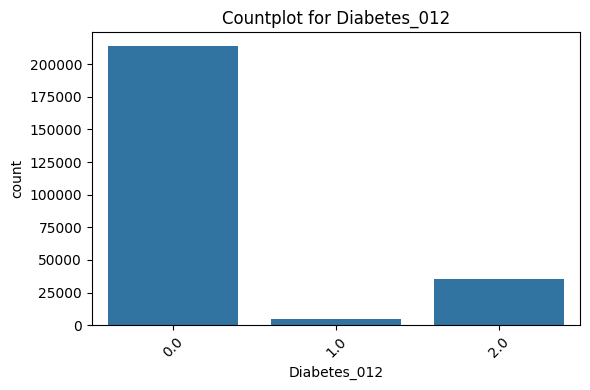

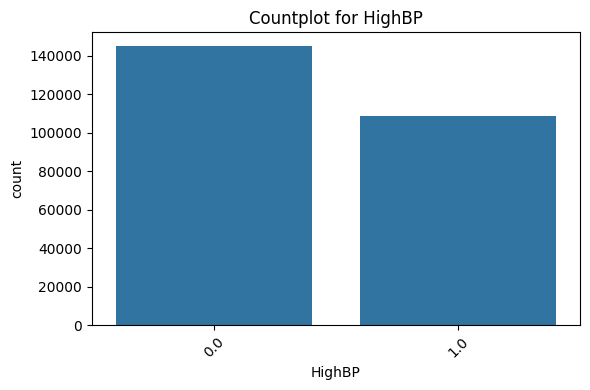

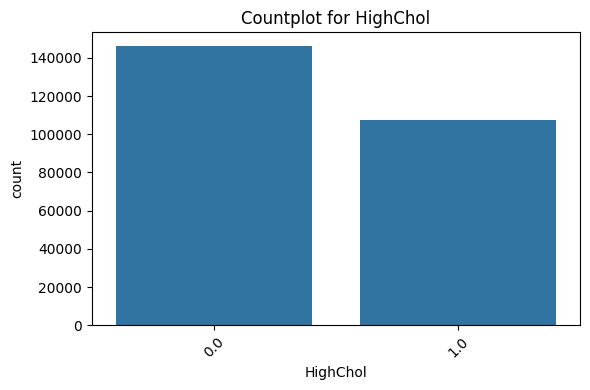

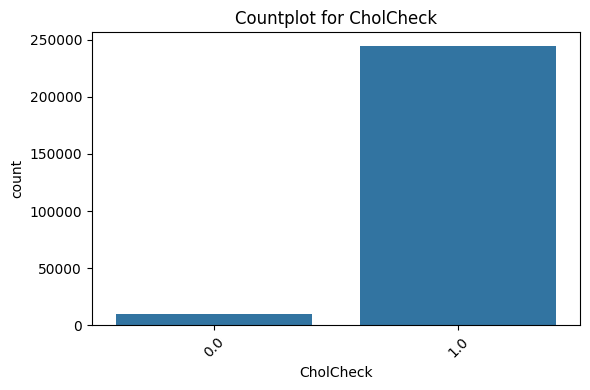

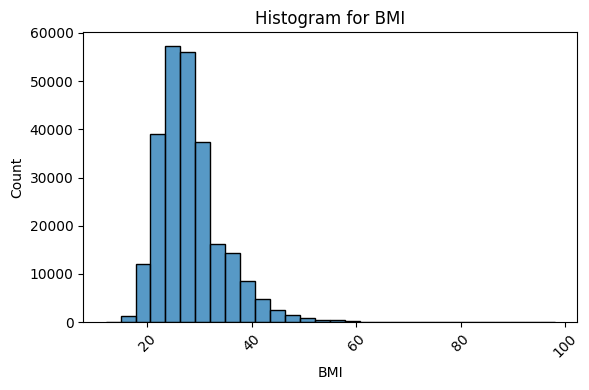

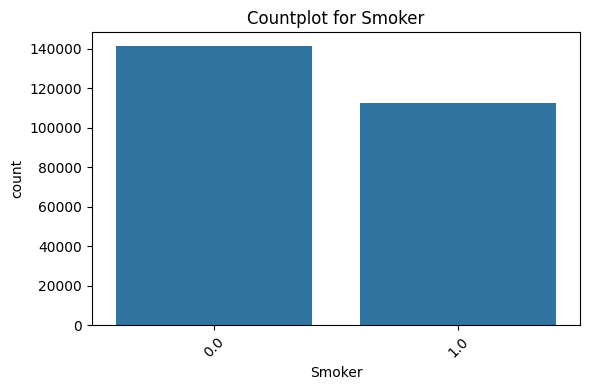

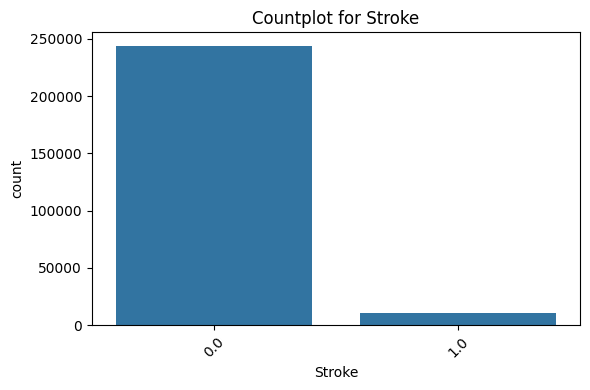

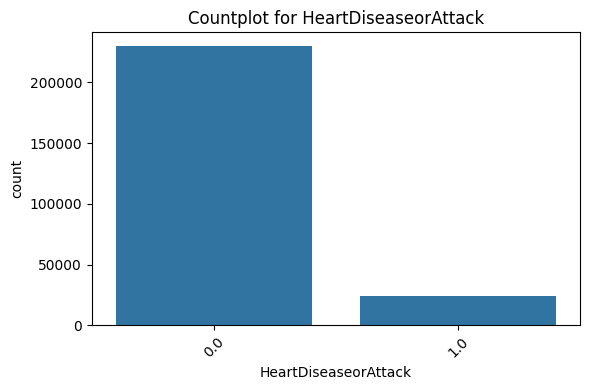

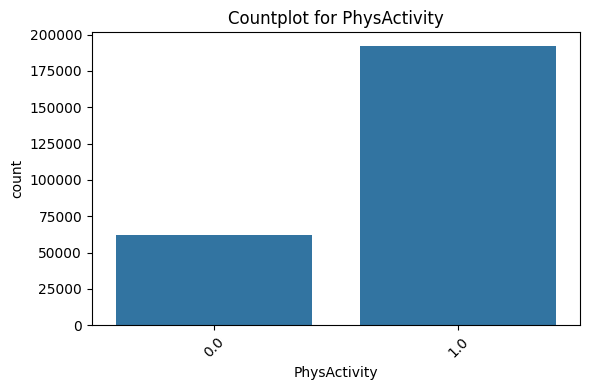

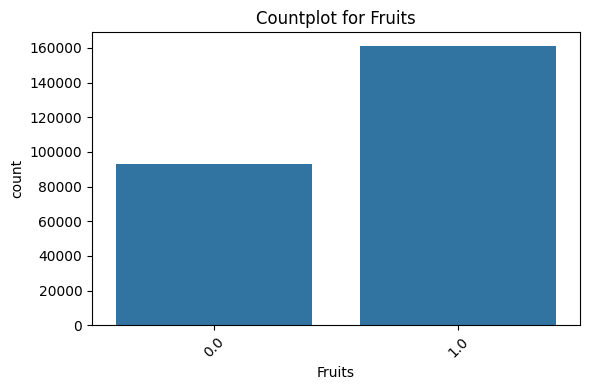

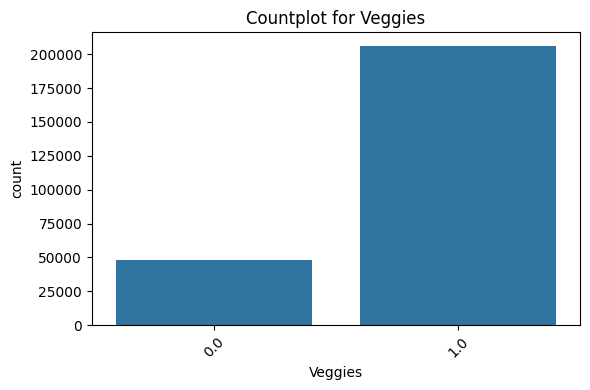

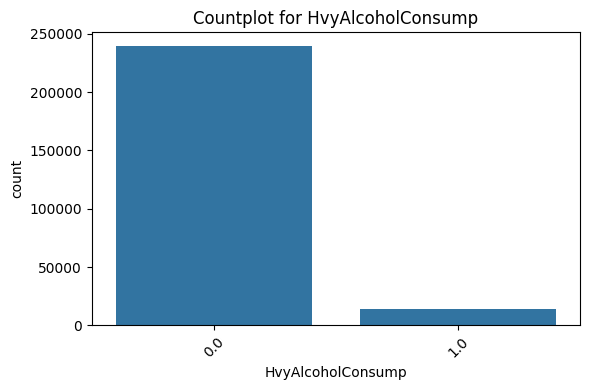

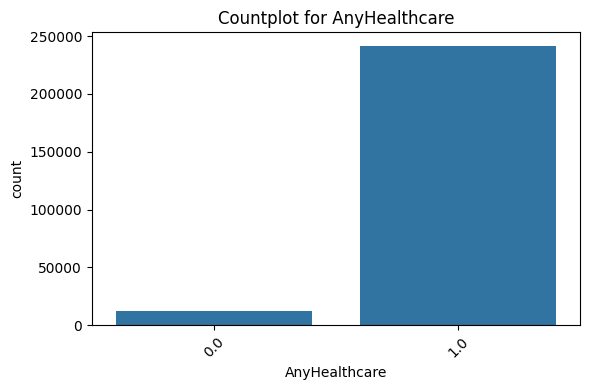

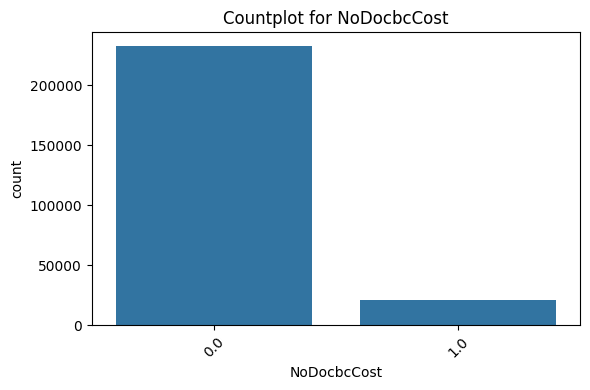

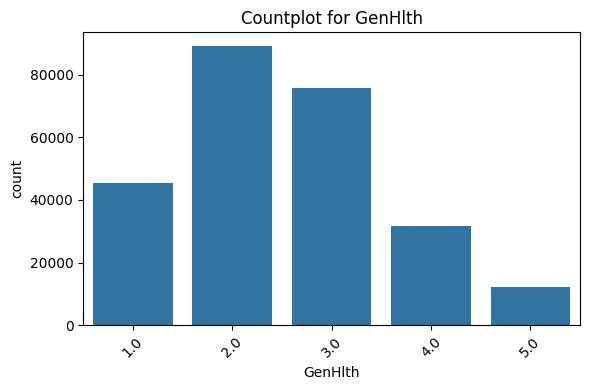

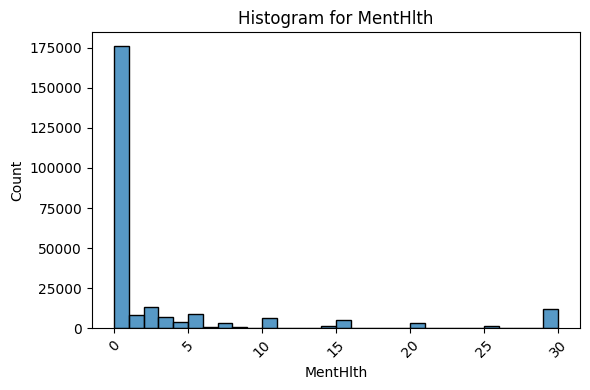

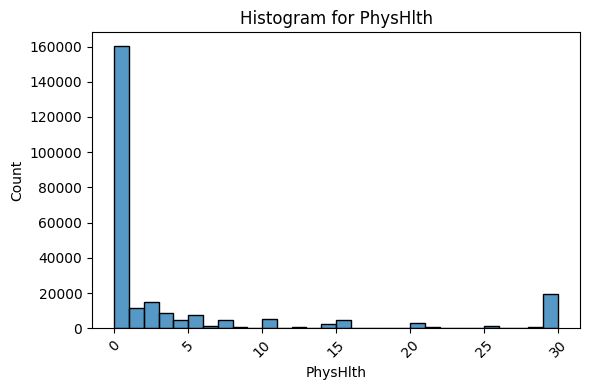

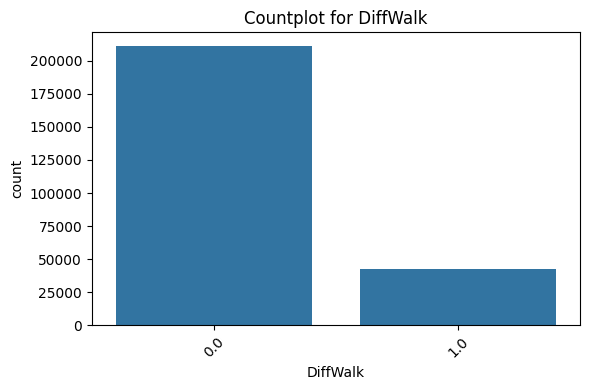

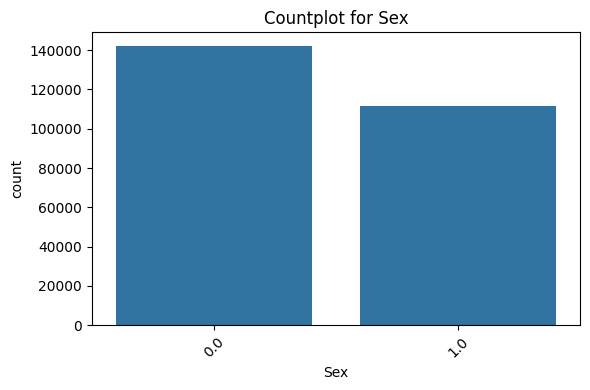

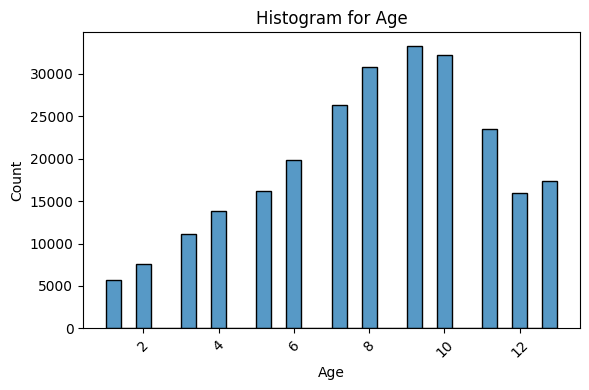

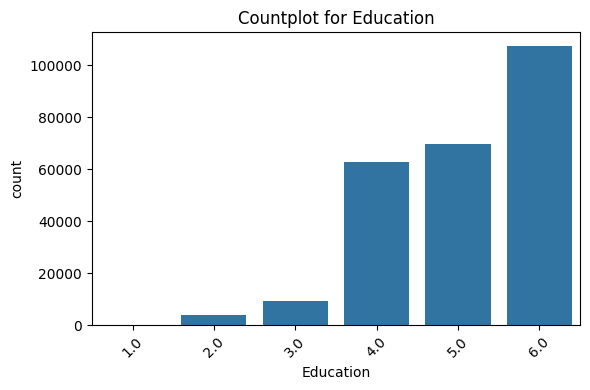

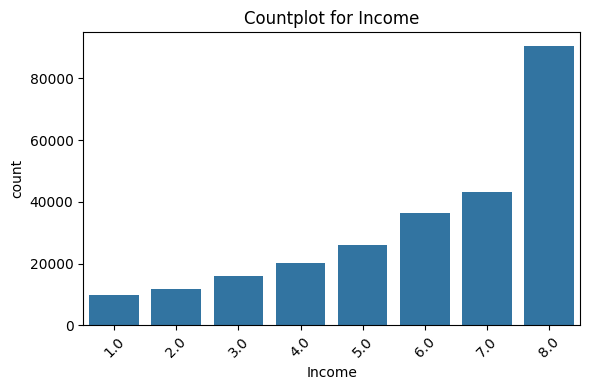

BMI_Category
Overweight       93749
Obese            87851
Normal Weight    68953
Underweight       3127
Name: count, dtype: int64
                      Diabetes_012    HighBP  HighChol  CholCheck       BMI    Smoker    Stroke  HeartDiseaseorAttack  PhysActivity    Fruits   Veggies  HvyAlcoholConsump  AnyHealthcare  NoDocbcCost   GenHlth  MentHlth  PhysHlth  DiffWalk       Sex       Age  Education    Income
Diabetes_012              1.000000  0.271668  0.210668   0.068018  0.235887  0.063040  0.105887              0.178564     -0.121988 -0.042268 -0.059353          -0.057244       0.014530     0.037379  0.297138  0.044921  0.161718  0.223567  0.030143  0.186357  -0.126862 -0.172611
HighBP                    0.271668  1.000000  0.298199   0.098508  0.243756  0.096991  0.129575              0.209361     -0.125267 -0.040555 -0.061266          -0.003972       0.038425     0.017358  0.303300  0.020499  0.149550  0.223618  0.052207  0.344535  -0.141970 -0.179161
HighChol                  0.2

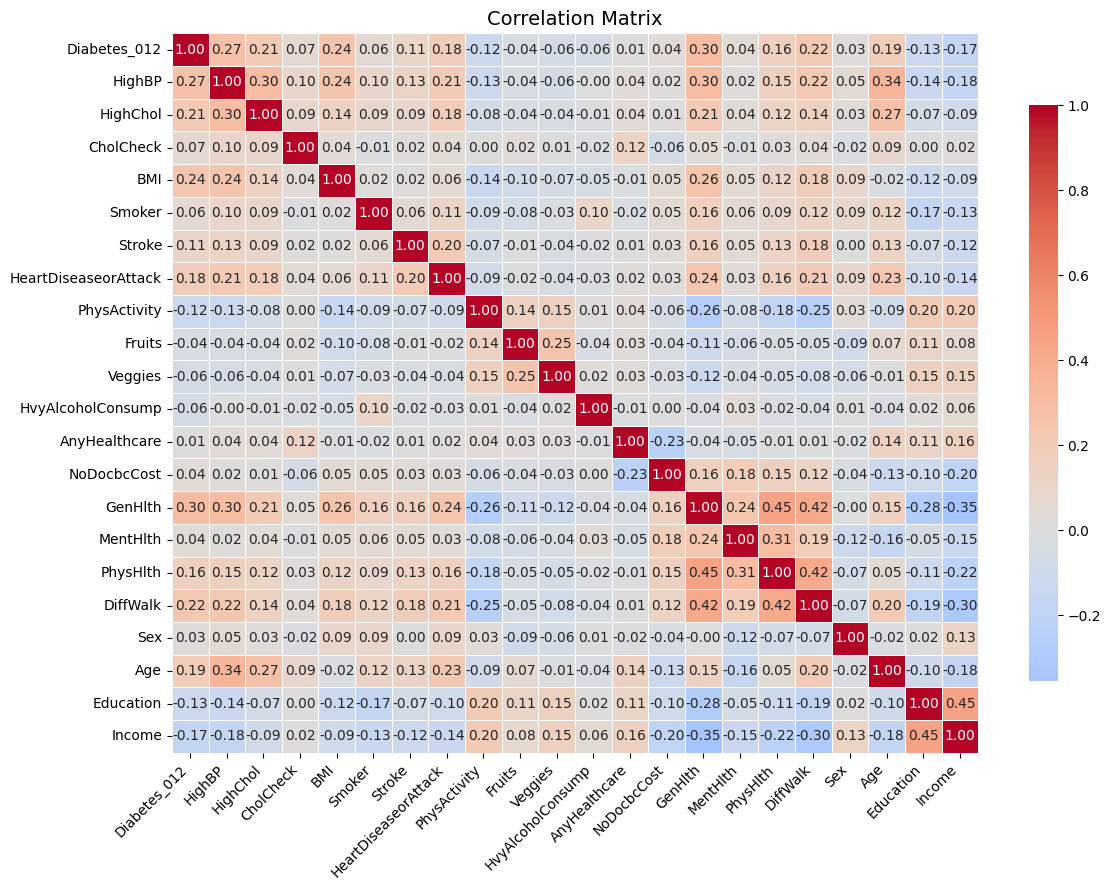

Diabetes_012            1.000000
GenHlth                 0.297138
HighBP                  0.271668
BMI                     0.235887
DiffWalk                0.223567
HighChol                0.210668
Age                     0.186357
HeartDiseaseorAttack    0.178564
PhysHlth                0.161718
Stroke                  0.105887
CholCheck               0.068018
Smoker                  0.063040
MentHlth                0.044921
NoDocbcCost             0.037379
Sex                     0.030143
AnyHealthcare           0.014530
Fruits                 -0.042268
HvyAlcoholConsump      -0.057244
Veggies                -0.059353
PhysActivity           -0.121988
Education              -0.126862
Income                 -0.172611
Name: Diabetes_012, dtype: float64


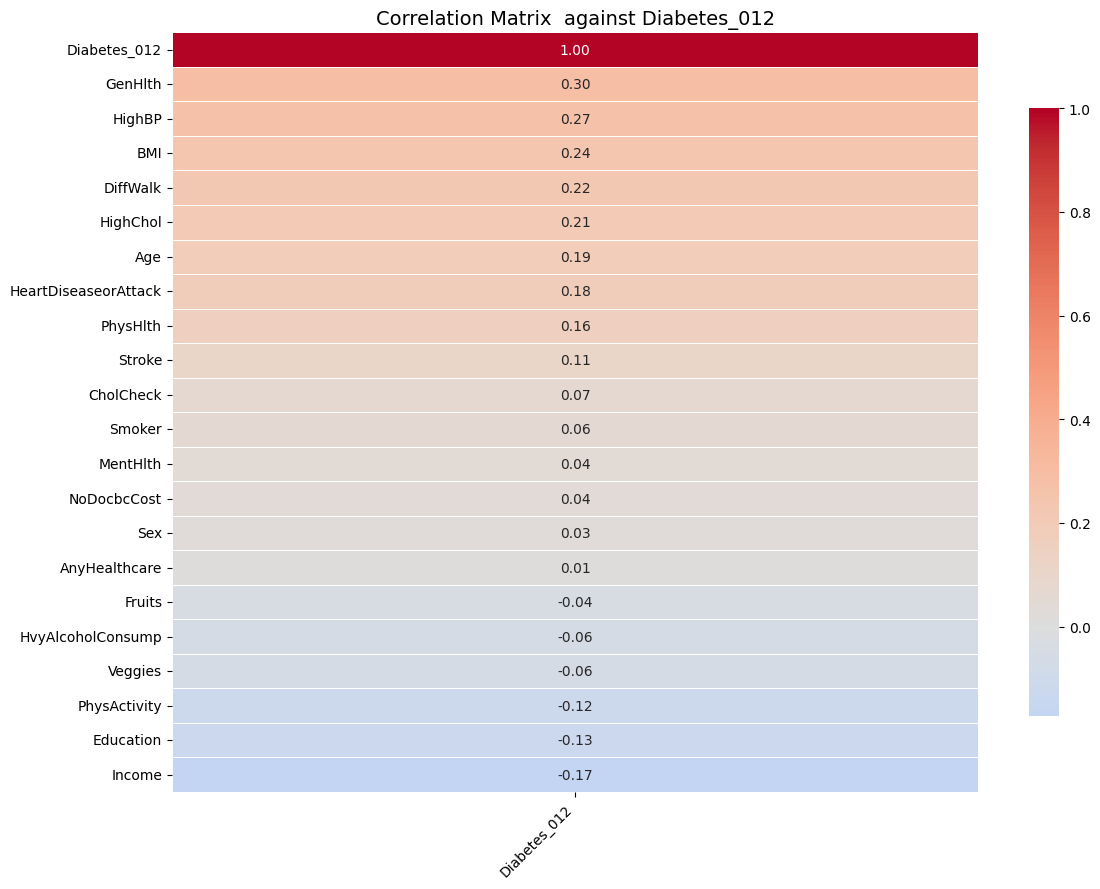

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler

# Load the CSV file 
df = pd.read_csv("diabetes.csv") 

# Set the display setting so that oclumns are shown across the screen and not truncated
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 2000)

# Review the features to see what they look like and to check distributions
print(df.shape)
print(df.head(10))
print(df.describe().T)
print(df.info)

 # Review the data types of each feature. All are floats! 
df.columns.to_list()
print("The datatypes are:\n", df.dtypes)

# Reviewing the unique values 
print("The number of unique values is:\n",df.nunique().sort_values())

# Reviewing the level of null values
print("The level of null values is:\n", df.isnull().sum())

# show all of the columns in diabetes with associated unique values
for column in df.columns:
    print(f"\ncolumn: {column}")
    print(sorted(df[column].unique()))

# Check for missing values. There are no missing or unusual values! This dataset is remarkably clean!
df.isna().sum().sort_values(ascending=False)

# EDA
# We will look at the distrubutions of all variables (as all are floats)
# Plot the data using bar charts 
for col in df.columns:
    plt.figure(figsize=(6,4))

    # If the column is binary or categorical (few unique values)
    if df[col].nunique() <= 10:
        sns.countplot(data=df, x=col)
        plt.title(f"Countplot for {col}")
    
    # If the column is numeric with many unique values
    else:
        sns.histplot(data=df, x=col, bins=30, kde=False)
        plt.title(f"Histogram for {col}")

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# Some of the features could be banded e.g. 
# BMI could be banded into 1: Underweight, 2: Normal weight, 3: Overweight, 4: Obese 
# 

# 1. BMI_Category
# 1     31273  
# 2    68953 
# 3    93749
# 4    87851

# Define the conditions for BMI categories
conditions = [
    df["BMI"] <= 18.5,  # Underweight
    (df["BMI"] > 18.5) & (df["BMI"] <= 24.8),  # Normal Weight
    (df["BMI"] >= 25) & (df["BMI"] <= 29.9),  # Overweight
    df["BMI"] >= 30  # Obese
]

values = ["Underweight", "Normal Weight", "Overweight", "Obese"]

# Apply np.select to categorize BMI
df["BMI_Category"] = np.select(conditions, values, default="Unknown")

# Display the value counts of the BMI categories
print(df["BMI_Category"].value_counts())



## Correlations: Need to specigy Correlations as Spearman as distribution are skewed/not normally distributed 
# 1. Correlation. Firstly do a full correlation of all features vs all features
df_numeric1 = df.select_dtypes(include=[np.number])
corr1 = df_numeric1.corr(method="spearman")
print(corr1)

plt.figure(figsize=(12, 9))
sns.heatmap(
    corr1,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)


plt.title("Correlation Matrix", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# Initital dataset saved to CSV format for review and analysis
df.to_csv("diabetes_cleaned.csv", index=False)


# 2. Correlation. Next do a corrrelation where the target is Diabetes_012
df_numeric2 = df.select_dtypes(include=[np.number])
corr2 = df_numeric2.corr(method="spearman")["Diabetes_012"].sort_values(ascending=False)
print(corr2)

# convert to datafrmae for heatmap!
corr_df=corr2.to_frame()
plt.figure(figsize=(12, 9))
sns.heatmap(
    corr_df,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)

plt.title("Correlation Matrix  against Diabetes_012", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Correlation summary: There are not that many strong correlations with Diabetes_012. GenHlth is the best one:
# Diabetes_012            1.000000
# GenHlth                 0.297138 - Worse general health, higher
# HighBP                  0.271668
# BMI                     0.235887
# DiffWalk                0.223567
# HighChol                0.210668
# Age                     0.186357
# HeartDiseaseorAttack    0.178564
# PhysHlth                0.161718
# Stroke                  0.105887
# CholCheck               0.068018
# Smoker                  0.063040
# MentHlth                0.044921
# NoDocbcCost             0.037379
# Sex                     0.030143
# AnyHealthcare           0.014530
# Fruits                 -0.042268
# HvyAlcoholConsump      -0.057244
# Veggies                -0.059353
# PhysActivity           -0.121988
# Education              -0.126862
# Income                 -0.172611





GenHlth: H=22480.9250, p=0.0000e+00 -> reject H0; medians={0: np.float64(2.0), 1: np.float64(3.0), 2: np.float64(3.0)}
BMI: H=14130.7500, p=0.0000e+00 -> reject H0; medians={0: np.float64(27.0), 1: np.float64(30.0), 2: np.float64(31.0)}
BMI_Category_Code: H=11767.4869, p=0.0000e+00 -> reject H0; medians={0: np.float64(3.0), 1: np.float64(4.0), 2: np.float64(4.0)}


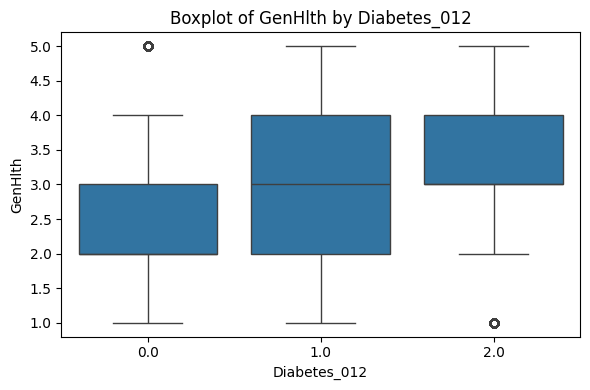

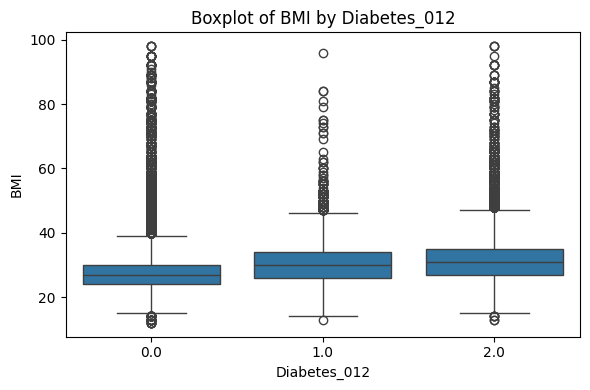

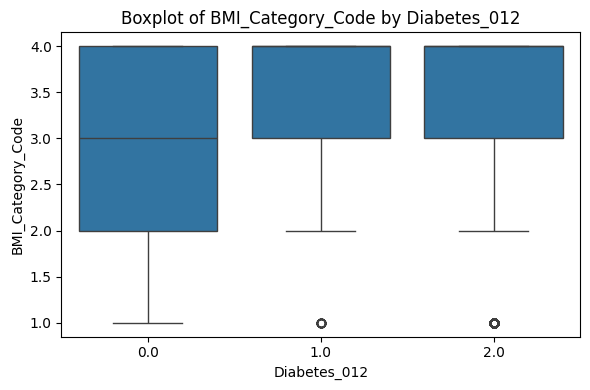

In [17]:
# --- Kruskal-Wallis (separate cell) --- Generated by the AI Assistant
from scipy.stats import kruskal

# Map BMI_Category to an ordinal code (if not already present)
bmi_order = ['Underweight', 'Normal Weight', 'Overweight', 'Obese']
bmi_map = {k: i+1 for i, k in enumerate(bmi_order)}
if 'BMI_Category' in df.columns:
    df['BMI_Category_Code'] = df['BMI_Category'].map(bmi_map)
else:
    # fallback: create BMI_Category then map
    conditions = [
        df['BMI'] <= 18.5,
        (df['BMI'] > 18.5) & (df['BMI'] <= 24.8),
        (df['BMI'] >= 25) & (df['BMI'] <= 29.9),
        df['BMI'] >= 30,
    ]
    values = ['Underweight', 'Normal Weight', 'Overweight', 'Obese']
    df['BMI_Category'] = np.select(conditions, values, default=np.nan)
    df['BMI_Category_Code'] = df['BMI_Category'].map(bmi_map)

vars_to_test = ['GenHlth', 'BMI', 'BMI_Category_Code']
alpha = 0.05
labels = sorted(df['Diabetes_012'].dropna().unique())

for var in vars_to_test:
    groups = [df.loc[df['Diabetes_012'] == g, var].dropna() for g in labels]
    non_empty = [grp for grp in groups if len(grp) > 0]
    if len(non_empty) < 2:
        print(f"Not enough non-empty groups for {var} - skipping")
        continue
    stat, p = kruskal(*non_empty)
    medians = {int(lbl): df.loc[df['Diabetes_012']==lbl, var].median() for lbl in labels}
    sig = 'reject H0' if p < alpha else 'fail to reject H0'
    print(f"{var}: H={stat:.4f}, p={p:.4e} -> {sig}; medians={medians}")

# Visualise with boxplots
for var in vars_to_test:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='Diabetes_012', y=var, data=df)
    plt.title(f"Boxplot of {var} by Diabetes_012")
    plt.tight_layout()
    plt.show()
    
# Results Summary: 
# GenHlth: People without diabetes report a median general health of 2 (“Very Good”), whilst people with prediabetes and diabetes 
# report a median of 3 (“Good”).
# Findings: General health declines across diabetes groups. Individuals without diabetes typically report “Very Good” health, whereas 
# those with prediabetes or diabetes report “Good” health. The difference is statistically significant (p < 0.001).

# BMI: People without diabetes report a lower BMI of median 27.0 (range=Overweight), whilst people with prediabetes and diabetes report
# a median of 30.0 and 31.0 respectively (Range=Obese).
# Findings: BMI increases steadily across diabetes groups. Individuals without diabetes typically fall in the Overwight range, whereas 
# those with prediabetes or diabetes fall in the Obese range. The difference is statistically significant (p < 0.001) reinforcing the 
# strong assocaition between higher BMIand diabetes severity.

In [18]:
# Chi Sqaure for all of the binary variables. What matters is the Cramers_V score.
# Results Summary: 
# Strongest predictors
# HighBP (V=0.272): Moderate, clincially meaningful
# DiffWalk (V=0.224): Moderate, clincially meaningful
# HighChol (V=0.211): Moderate, clincially meaningful

# Weaker but still relevant predictors
# HeartDiseaseAttack(V=0.180): Weak but still clinically meaningful
# PhysActivity (V=0.122): Weak but still clinically meaningful
# Stroke (V=0.107): Weak but still clinically meaningful

# Findings to date: 
# The strongest predicotrs of diabetes are High Blood Presssure, High cholesterol, High BMI/Obesity, poorer general health. mobility ddifficulty and older age.

# Moderator predictors are heart disease, physical inactivity and stroke

# Weak predictors are: smoking, diet (fruit/vegetables), alcohol, sex and education  

# Logistic Regression


In [20]:
# Chi-square tests for specified binary variables vs Diabetes_012 — combined summary table
from scipy.stats import chi2_contingency
import numpy as np
import pandas as pd

binary_vars = [
    'HighBP',
    'HighChol',
    'Stroke',
    'HeartDiseaseorAttack',
    'PhysActivity',
    'Smoker',
    'Fruits',
    'Veggies',
    'HvyAlcoholConsump',
    'Sex',
    'DiffWalk',
    'NoDocbcCost'
 ]
labels = sorted(df['Diabetes_012'].dropna().unique())

def cramers_v(confusion_matrix):
    chi2, p, dof, expected = chi2_contingency(confusion_matrix)
    n = confusion_matrix.values.sum()
    r, k = confusion_matrix.shape
    if n == 0 or min(r-1, k-1) == 0:
        return np.nan
    return np.sqrt(chi2 / (n * min(r-1, k-1)))

results = []
print('Computing chi-square and Cramer\'s V for binary variables vs Diabetes_012...\n')
for var in binary_vars:
    if var not in df.columns:
        print(f"{var}: NOT IN DATA -- skipping\n")
        continue
    ct = pd.crosstab(df[var], df['Diabetes_012'])
    if ct.size == 0:
        print(f"{var}: empty crosstab -- skipping\n")
        continue
    try:
        chi2, p, dof, expected = chi2_contingency(ct)
        cv = cramers_v(ct)
        # counts of 'positive' (value==1) per Diabetes_012 group when applicable
        row = {'variable': var, 'chi2': chi2, 'p': p, 'dof': dof, 'cramers_v': cv}
        is_binary_one = df[var].isin([1]).any()
        for lbl in labels:
            col_name = f'pos_count_{int(lbl)}'
            if is_binary_one:
                cnt = int(df.loc[(df[var] == 1) & (df['Diabetes_012'] == lbl)].shape[0])
            else:
                cnt = np.nan
            row[col_name] = cnt
        results.append(row)
    except Exception as e:
        print(f"Error testing {var}: {e}\n")

# Build summary dataframe
if results:
    res_df = pd.DataFrame(results)
    # ensure pos_count columns appear in order 0,1,2 if present
    pos_cols = [c for c in res_df.columns if c.startswith('pos_count_')]
    ordered_cols = ['variable', 'chi2', 'p', 'dof', 'cramers_v'] + sorted(pos_cols)
    res_df = res_df[ordered_cols]
    res_df = res_df.sort_values('cramers_v', ascending=False).reset_index(drop=True)
    print('Summary table (sorted by Cramer\'s V):')
    display(res_df)
else:
    print('No results to display')

Computing chi-square and Cramer's V for binary variables vs Diabetes_012...

Summary table (sorted by Cramer's V):


,variable,chi2,p,dof,cramers_v,pos_count_0,pos_count_1,pos_count_2
0,HighBP,18794.644052,0.000000e+00,2,0.272191,79312,2913,26604
1,DiffWalk,12776.941889,0.000000e+00,2,0.224425,28269,1285,13121
2,HighChol,11258.920399,0.000000e+00,2,0.210671,81030,2875,23686
3,HeartDiseaseorAttack,8244.889107,0.000000e+00,2,0.180281,15351,664,7878
4,PhysActivity,3789.301463,0.000000e+00,2,0.122218,166491,3142,22287
5,Stroke,2916.751980,0.000000e+00,2,0.107228,6759,265,3268
6,Smoker,1010.511751,3.716732e-220,2,0.063114,91824,2282,18317
7,Veggies,893.841905,8.029646e-195,2,0.059359,175544,3561,26736
8,HvyAlcoholConsump,850.324048,2.261930e-185,2,0.057896,13216,208,832
9,Fruits,454.347059,2.186703e-99,2,0.042320,137416,2789,20693
